# PyTorch Workflow Fundamentals

This is a demonstration of the usage of PyTorch through the problem of predicting a line.

## Preparing and loading data

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
w = 0.7
b = 0.3
X = torch.rand(50, 1)
y = w * X + b

In [3]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [4]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    if (predictions is not None):
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    plt.legend(prop={"size": 14})

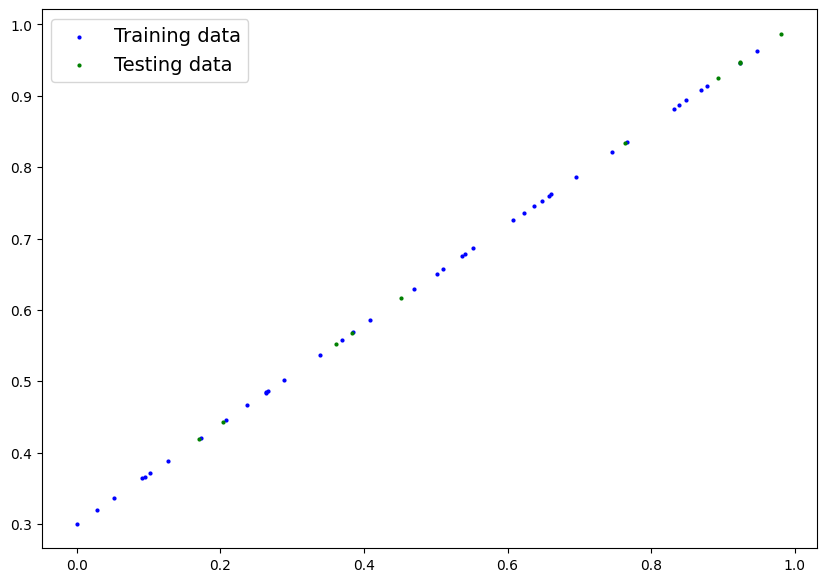

In [5]:
plot_predictions()

## Building a model

`torch.nn.Module` is the base class for all neural networks.  
Its subclasses must override the `forward()` method.  
`torch.nn.Parameter` stores tensors that can be used with `torch.nn.Module`.  
`torch.randn()` generates a random number from a Gaussian distribution with mean `0` and variance `1`.  
The `requires_grad` attribute is set to `True` if we want the parameters to be updated automatically (also known as autograd).

In [6]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))
        self.bias = torch.nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [7]:
torch.manual_seed(42)
model = LinearRegressionModel()
print(list(model.parameters()))
print(model.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


## Training a model

The `torch.nn.L1Loss` class corresponds to the MAE (mean absolute error) loss function.  
An opptmizer tells a model how to update its parameters to best lower the loss.  
The `torch.optim.SGD` class corresponds to the SGD (stochastic gradient descent) optimizer.  
The `params` attribute is set to the model parameters and the `lr` attribute is used to set the learning rate.

In [8]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

The `train()` and `eval()` methods are used to switch between `torch.nn.Module` states (the default state is train).  
To perform forward propagation, the module is directly called as a function, with the training input data passed as a parameter.  
The `zero_grad()` method resets the optimizer gradients to `0`, as they by default accumulate over epochs.  
The `backward()` method computes the gradient of every module parameter whose `requires_grad` attribute is set to `0`.  
The `step()` method updates the parameters with respect to their calculated loss gradients.  
`torch.inference_mode` is a context manager class that used for inference.  
A context manager performs a pre-defined set of actions before and after the code it is used with.

In [9]:
torch.manual_seed(42)
epochs = 100
train_loss_values = []
test_loss_values = []
epoch_count = []
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch {epoch} | MAE train loss: {loss} | MAE test loss: {test_loss}")

Epoch 0 | MAE train loss: 0.3436099886894226 | MAE test loss: 0.37833109498023987
Epoch 10 | MAE train loss: 0.22108738124370575 | MAE test loss: 0.24959135055541992
Epoch 20 | MAE train loss: 0.10408703982830048 | MAE test loss: 0.12596549093723297
Epoch 30 | MAE train loss: 0.05956023186445236 | MAE test loss: 0.0706312507390976
Epoch 40 | MAE train loss: 0.04752732068300247 | MAE test loss: 0.056306142359972
Epoch 50 | MAE train loss: 0.041688770055770874 | MAE test loss: 0.04950486868619919
Epoch 60 | MAE train loss: 0.03710026666522026 | MAE test loss: 0.04400130733847618
Epoch 70 | MAE train loss: 0.032533980906009674 | MAE test loss: 0.03849773108959198
Epoch 80 | MAE train loss: 0.027967700734734535 | MAE test loss: 0.03299415856599808
Epoch 90 | MAE train loss: 0.023403501138091087 | MAE test loss: 0.027570974081754684


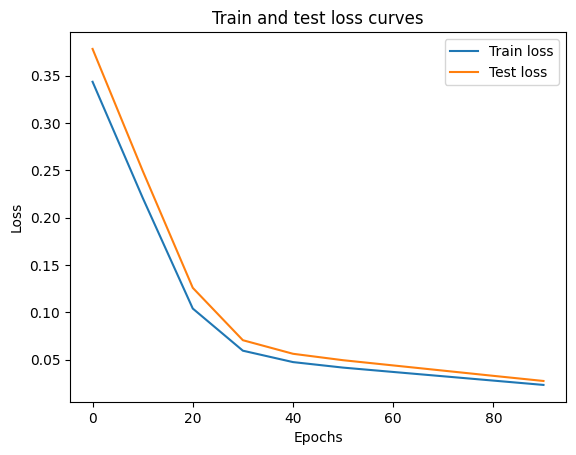

In [10]:
plt.plot(epoch_count, train_loss_values, label = "Train loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.title("Train and test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [11]:
print(model.state_dict())
print(f"Original values are weights: {w} and bias: {b}")

OrderedDict([('weights', tensor([0.6224])), ('bias', tensor([0.3418]))])
Original values are weights: 0.7 and bias: 0.3


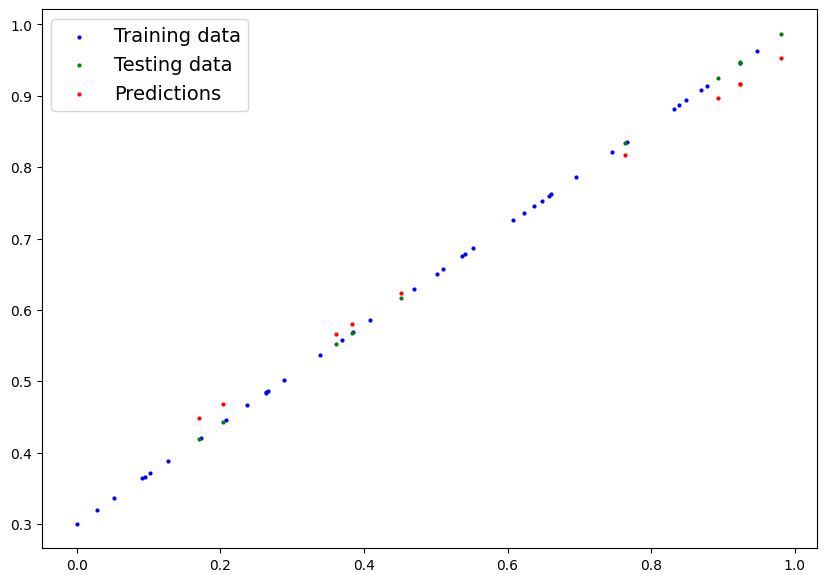

In [12]:
model.eval()
with torch.inference_mode():
    y_pred = model(X_test)
plot_predictions(predictions=y_pred)

## Saving and loading a model

`torch.save()` and `torch.load()` use Python's `pickle` utility to serialise and de-serialise Python objects.

In [13]:
from pathlib import Path

In [14]:
MODEL_PATH = Path("models")
MODEL_NAME = "01_linear_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_linear_model.pth


In [15]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

## Using Linear instead of Parameter

In [16]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super.__init__()
        self.linear_layer = torch.nn.Linear(in_features=1, out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)